# Flood Duration


Run the setup notebook, establish the data and output directories.

In [1]:
%run setup.ipynb
data_dir = Path('../data' )
output_dir = Path('../output') 

Load the data. Here we'll add the daily max sea levels netcdf file. 

In [2]:
# load the data
SL_daily_max = xr.open_dataset(data_dir / 'SL_daily_max.nc')
SL_daily_max.close()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jfiedler/Documents/Repositories/SL_Hawaii/SL_Hawaii/data/SL_daily_max.nc'

Now we'll extract the necessary data, and run a loop through all time for all stations to establish "events," which takes all consecutive days above the theshold level. In doing so we are establishing counts of long-duration flooding (repeated days). 

In [3]:
# Extracting the necessary data
flood_day = SL_daily_max['flood_day']
time = SL_daily_max['time']
station_names = SL_daily_max['station_name'].values

# Convert time to pandas datetime
time = pd.to_datetime(time.values)

# Initialize a dictionary to hold results
flood_events = {}

# Loop through each station
for i, station in enumerate(station_names):
    station_flood_days = flood_day[:, i].values
    station_flood_days = pd.Series(station_flood_days, index=time)
    
    # Initialize list to hold all events for this station
    station_events = []
    current_event_length = 0
    
    for day in station_flood_days:
        if day:
            current_event_length += 1
        else:
            if current_event_length > 0:
                station_events.append(current_event_length)
                current_event_length = 0
    
    # Append the last event if it was ongoing at the end of the series
    if current_event_length > 0:
        station_events.append(current_event_length)
    
    # Store the results for the station
    flood_events[station] = station_events


## Plot Histograms
These histograms show us the distribution of the duration of flood events at each station.

Text(0.04, 0.5, 'Frequency')

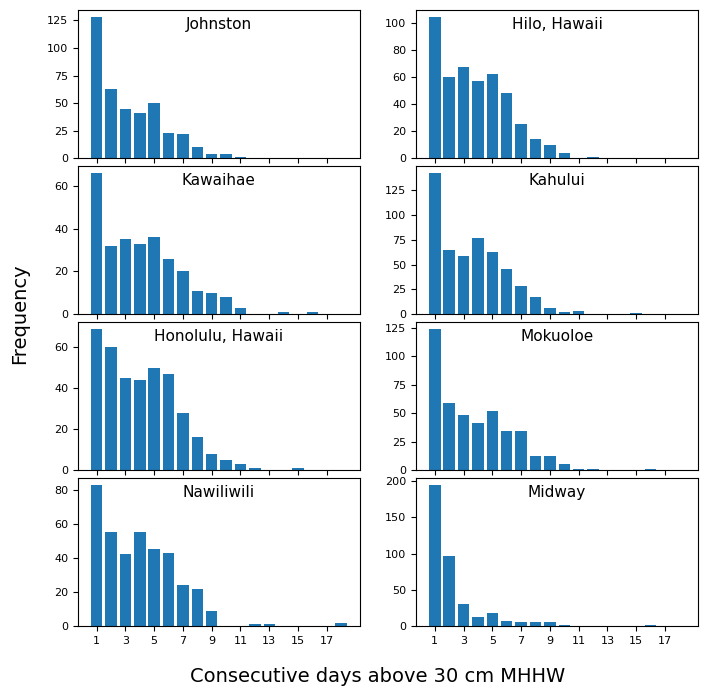

In [4]:
 # Get histogram of events for all years for each station
event_counts = {station: [] for station in station_names}


# Plot histograms using subplots
fig, axes = plt.subplots(4,2, figsize=(8,8), gridspec_kw={'hspace': 0.05})  # Adjusted to 4x2 grid with minimal vertical space


for i, (station, events) in enumerate(flood_events.items()):
    ax = axes[i // 2, i % 2]
    ax.hist(events, bins=range(1, 20), align='left', rwidth=0.8)
    ax.text(0.5, 0.9, station, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=11)
    ax.tick_params(axis='both', which='major', labelsize=8)  # Make tick labels smaller
    if i // 2 < 3:  # Remove x-tick labels for upper plots
        ax.set_xticklabels([])
    ax.set_xticks(range(1, 19,2))  # Ensure x-ticks are integers


# Set only one x-axis and one y-axis label
fig.text(0.5, 0.04, 'Consecutive days above 30 cm MHHW', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')



Note again that consecutive days above 30cm MHHW means that the sea level meets or exceeds that threshold at least once per day consecutively, e.g. two consecutive higher-high tides.


In [5]:
flood_events.keys()


dict_keys(['Johnston', 'Hilo, Hawaii', 'Kawaihae', 'Kahului', 'Honolulu, Hawaii', 'Mokuoloe', 'Nawiliwili', 'Midway'])

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the number of rows and columns for the subplots
rows, cols = 4, 2

# Create a subplot grid with minimal spacing
fig = make_subplots(
    rows=rows, cols=cols, 
    vertical_spacing=0.01, horizontal_spacing=0.05  # Reduced spacing between subplots
)

# Plot histograms for each station
for i, (station, events) in enumerate(flood_events.items()):
    row = (i // cols) + 1
    col = (i % cols) + 1
    
    # Define the hovertemplate with units
    hovertemplate = (
        "Duration: %{x} days<br>" +
        "Event Count: %{y} " +
        "<extra></extra>"
    )

    fig.add_trace(go.Histogram(
        x=events,
        xbins=dict(start=1, end=20, size=1),  # Ensure each bin corresponds to 1 day
        marker=dict(color="rgba(31, 119, 180, 0.7)", line=dict(width=1, color='rgba(31, 119, 180, 1)')),  # Blue color with transparency
        showlegend=False,
        hovertemplate=hovertemplate,
    ), row=row, col=col)
    
    # Set outline for each subplot
    fig.update_xaxes(showline=True, linewidth=0.2, linecolor='lightgrey', mirror=True, row=row, col=col,tickfont=dict(size=8),range = [1,20], matches='x')
    fig.update_yaxes(showline=True, linewidth=0.2, linecolor='lightgrey', mirror=True, row=row, col=col,tickfont=dict(size=8),)
    # fig.update_annotations(selector=dict(row=row, col=col), font=dict(size=12))  # Adjust title font size
    
    # Remove x-axis labels from all rows except the last one
    if row < rows:
        fig.update_xaxes(showticklabels=False, row=row, col=col)

    fig.add_annotation(
        text=station,
        x=0.5, y=0.87,  # Position in the top right corner
        xref="x domain",  # Reference the x-axis domain of the subplot
        yref="y domain",  # Reference the y-axis domain of the subplot
        row=row,  # Reference the x-axis domain of the subplot
        col=col,  # Reference the y-axis domain of the subplot
        showarrow=False,
        font=dict(size=10),
        xanchor='center', yanchor='top'
    )


# Add the x-axis label using an annotation and nudge it to the right
fig.add_annotation(
    text="Consecutive days above 30 cm MHHW",
    x=0.5,  # Centered horizontally
    y=-0.12,  # Position it below the bottom row of subplots
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14),
    xanchor="center",  # You can change this to "left" or "right" to further adjust
)

# Add the x-axis label using an annotation and nudge it to the right
fig.add_annotation(
    text="Event Count (1983-2023)",
    y=0.5,  
    x=-0.1,  
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14),
    yanchor="middle",  # You can change this to "left" or "right" to further adjust
    textangle=-90
)



# Adjust layout to ensure a white background and reduce spacing between plots
fig.update_layout(
    height=400, width=500,  # Set the figure size
    margin=dict(t=50, b=50, l=50, r=50),  # Ensure enough space for titles and labels
    bargap=0.2,  # Increase space between bars
    plot_bgcolor='white',  # Ensure the background of the plot is white
    paper_bgcolor='white',  # Set the paper background color to white
)

# Show the interactive plot
fig.show()

#save html
matrix_dir = Path('../matrix/plotly')
fig.write_html(matrix_dir / 'flood_duration_histograms.html', full_html=True)

In [7]:
import plotly.graph_objects as go
import seaborn as sns

# Use the Seaborn "Set1" palette
palette = sns.color_palette("Set1", n_colors=8)
colors = [f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.5)" for r, g, b in palette]  # 0.5 for 50% transparency

# Convert the flood_events dictionary into a format suitable for Plotly
data = []

for color, (station, events) in zip(colors, flood_events.items()):
    data.append(go.Box(
        y=events,
        name=station,
        boxmean=True,  # To show the mean line
        boxpoints='outliers',  # Show only outliers as points
        line=dict(width=2, color=color.replace("0.5", "1")),  # Use solid color for the box outline
        fillcolor=color,  # Use the Seaborn color with transparency
        marker=dict(color=color.replace("0.5", "1"))  # Use solid color for markers
    ))

# Create the figure
fig = go.Figure(data=data)

# Update layout
fig.update_layout(
    
    title="Distribution of Flood Event Lengths by Station",
    yaxis_title="Consecutive Days Above 30 cm MHHW",
    xaxis_title="Station",
    xaxis_tickangle=-45,  # Rotate station names
    template="plotly_white"  # Use a white background template for clarity
)

# Show the interactive plot
fig.show()


There will be more. This is a placeholder.